# 

#  <span style="color:lightblue" font="bold"> Baseline Tumor Categorization </span>

In [1]:
### Importing the necessary libraries

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from PIL import Image

#### 1. <span style="color:lightblue" font="bold"> Loading the dataset </span>

In [2]:
# Define the path to the classification dataset (relative to the notebook location)
data_dir = Path("../raw_data/classification/Training")
test_dir = Path("../raw_data/classification/Testing")
os.listdir(data_dir)
os.listdir(test_dir)

['pituitary', '.DS_Store', 'notumor', 'glioma', 'meningioma']

In [3]:
FILE_PATH = Path("../raw_data/brain_tumor_df_processed.pkl")
df_charge = pd.read_pickle(FILE_PATH)
df_charge.head()

df_charge.drop(columns=['tumorMask', 'PID', 'filename'], inplace= True)
mapping = {
    1: 'meningioma',
    2: 'glioma',
    3: 'pituitary'
}

df_charge["tumor_type_encoded"] = df_charge.label.map(mapping)

In [4]:
# 1. Rename tumor_type_encoded -> tumor_type
df_charge = df_charge.rename(columns={"tumor_type_encoded": "tumor_type"})

# 2. Create new tumor_type_encoded from label
df_charge["tumor_type_encoded"] = df_charge["label"]

# 3. (Optional) Drop the old label column
df_charge = df_charge.drop(columns=["label"])

# 4. (Optional) Reorder columns exactly as you want
df_charge = df_charge[["image", "tumor_type", "tumor_type_encoded"]]

df_charge.head()

,image,tumor_type,tumor_type_encoded
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",pituitary,3
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",pituitary,3
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",pituitary,3
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",pituitary,3
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",pituitary,3


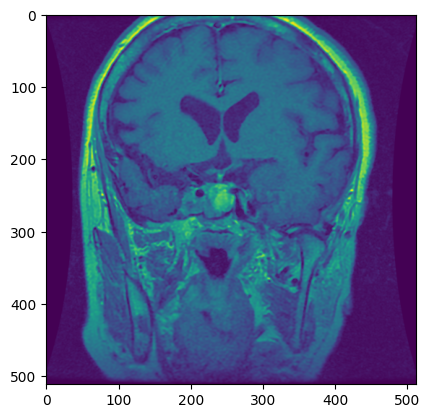

In [5]:
plt.imshow(df_charge.image[0])

#### 1.1 Removing duplicates

In [6]:
from pathlib import Path
import hashlib
import os

# --- Paramès ---
DATASET_ROOT = Path("../raw_data/classification")  # dossier racine contenant Training/ et Testing/
CLASSES = ["glioma", "pituitary", "meningioma", "notumor"]
SPLITS_ORDER = ["Training", "Testing"]  # Priorité : on garde ce qu'on voit en premier
EXTENSIONS = (".jpg", ".jpeg", ".png", ".bmp")  # adapte si besoin
DRY_RUN = False  # Mettre False pour réellement supprimer les fichiers

# ----------------------------

def file_hash(path, algo="md5", block_size=65536):
    """Hash du fichier basé sur son contenu (rapide et robuste pour duplicats exacts)."""
    h = hashlib.new(algo)
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(block_size), b""):
            h.update(chunk)
    return h.hexdigest()


def list_all_images():
    """Retourne la liste de tous les chemins d’images (Training + Testing, toutes classes)."""
    all_paths = []
    for split in SPLITS_ORDER:  # Training d'abord, puis Testing
        for cls in CLASSES:
            folder = DATASET_ROOT / split / cls
            if not folder.exists():
                print(f"⚠️ Dossier absent : {folder}")
                continue
            for ext in EXTENSIONS:
                all_paths.extend(folder.rglob(f"*{ext}"))
    return all_paths


def find_duplicates(paths):
    """
    Retourne:
        - hash_to_files: dict hash -> [liste des fichiers]
        - duplicates: liste de listes [fichier_à_garder, fichier_dup1, fichier_dup2, ...]
    """
    hash_to_files = {}
    for i, p in enumerate(paths, 1):
        if i % 500 == 0:
            print(f"Scanné {i} fichiers...")
        h = file_hash(p)
        hash_to_files.setdefault(h, []).append(p)

    duplicates_groups = []
    for h, files in hash_to_files.items():
        if len(files) > 1:
            # garder le premier (selon ordre SPLITS_ORDER)
            keep = files[0]
            dups = files[1:]
            duplicates_groups.append([keep] + dups)

    return hash_to_files, duplicates_groups


def main():
    print("🔍 Listing des images...")
    all_paths = list_all_images()
    print(f"Total d'images trouvées : {len(all_paths)}")

    print("🧮 Calcul des hash et recherche des doublons...")
    _, duplicates_groups = find_duplicates(all_paths)

    if not duplicates_groups:
        print("✅ Aucun doublon exact trouvé.")
        return

    total_dups = sum(len(g) - 1 for g in duplicates_groups)
    print(f"⚠️ Nombre de groupes de doublons : {len(duplicates_groups)}")
    print(f"⚠️ Nombre total de fichiers en trop : {total_dups}\n")

    # Afficher un aperçu
    print("Exemple de groupe de doublons :")
    for g in duplicates_groups[:3]:  # maximum 3 groupes affichés
        print("  À garder :", g[0])
        for d in g[1:]:
            print("    Doublon :", d)
        print()

    if DRY_RUN:
        print("Mode DRY_RUN = True : aucun fichier ne sera supprimé.")
        print("Si tout te semble OK, passe DRY_RUN à False et relance.")
        return

    # Suppression effective
    print("🗑 Suppression des doublons...")
    deleted = 0
    for group in duplicates_groups:
        to_delete = group[1:]  # on garde group[0]
        for f in to_delete:
            try:
                os.remove(f)
                deleted += 1
            except Exception as e:
                print(f"Erreur en supprimant {f}: {e}")

    print(f"✅ Suppression terminée. Fichiers supprimés : {deleted}")


# if __name__ == "__main__":
main()

🔍 Listing des images...
Total d'images trouvées : 13899
🧮 Calcul des hash et recherche des doublons...
Scanné 500 fichiers...
Scanné 1000 fichiers...
Scanné 1500 fichiers...
Scanné 2000 fichiers...
Scanné 2500 fichiers...
Scanné 3000 fichiers...
Scanné 3500 fichiers...
Scanné 4000 fichiers...
Scanné 4500 fichiers...
Scanné 5000 fichiers...
Scanné 5500 fichiers...
Scanné 6000 fichiers...
Scanné 6500 fichiers...
Scanné 7000 fichiers...
Scanné 7500 fichiers...
Scanné 8000 fichiers...
Scanné 8500 fichiers...
Scanné 9000 fichiers...
Scanné 9500 fichiers...
Scanné 10000 fichiers...
Scanné 10500 fichiers...
Scanné 11000 fichiers...
Scanné 11500 fichiers...
Scanné 12000 fichiers...
Scanné 12500 fichiers...
Scanné 13000 fichiers...
Scanné 13500 fichiers...
✅ Aucun doublon exact trouvé.


##### 1.2 Creating a dataframe of images paths and labels

In [7]:
# Collect image paths and their corresponding tumor types
image_paths = []
labels = []

for tumor_type in os.listdir(data_dir):
    tumor_type_path = data_dir/tumor_type
    if os.path.isdir(tumor_type_path):
        for img_name in os.listdir(tumor_type_path):
            img_path = tumor_type_path / img_name
            # Optional: filter only image files
            if img_path.suffix.lower() in [".png", ".jpg", ".jpeg"]:
                image_paths.append(str(img_path))
                labels.append(tumor_type)

# Create a DataFrame for the dataset
df = pd.DataFrame({
    "image_path": image_paths,
    "tumor_type": labels
})

# Show the first few rows for verification
print(df.shape)
df.head(10)


(11410, 2)


,image_path,tumor_type
0,../raw_data/classification/Training/pituitary/...,pituitary
1,../raw_data/classification/Training/pituitary/...,pituitary
2,../raw_data/classification/Training/pituitary/...,pituitary
3,../raw_data/classification/Training/pituitary/...,pituitary
4,../raw_data/classification/Training/pituitary/...,pituitary
5,../raw_data/classification/Training/pituitary/...,pituitary
6,../raw_data/classification/Training/pituitary/...,pituitary
7,../raw_data/classification/Training/pituitary/...,pituitary
8,../raw_data/classification/Training/pituitary/...,pituitary
9,../raw_data/classification/Training/pituitary/...,pituitary


<Axes: xlabel='tumor_type', ylabel='count'>

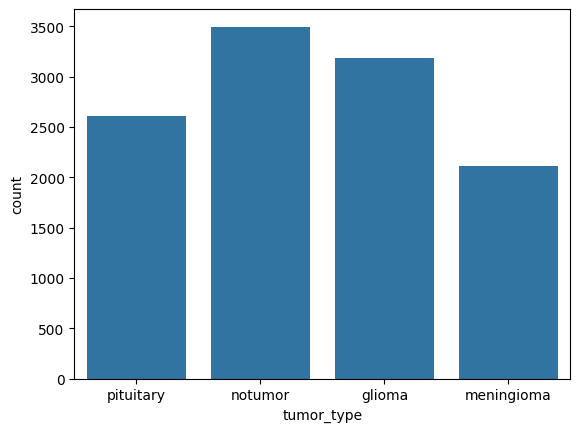

In [8]:
sns.countplot(x="tumor_type", data=df)

##### 1.2 Check the image loading

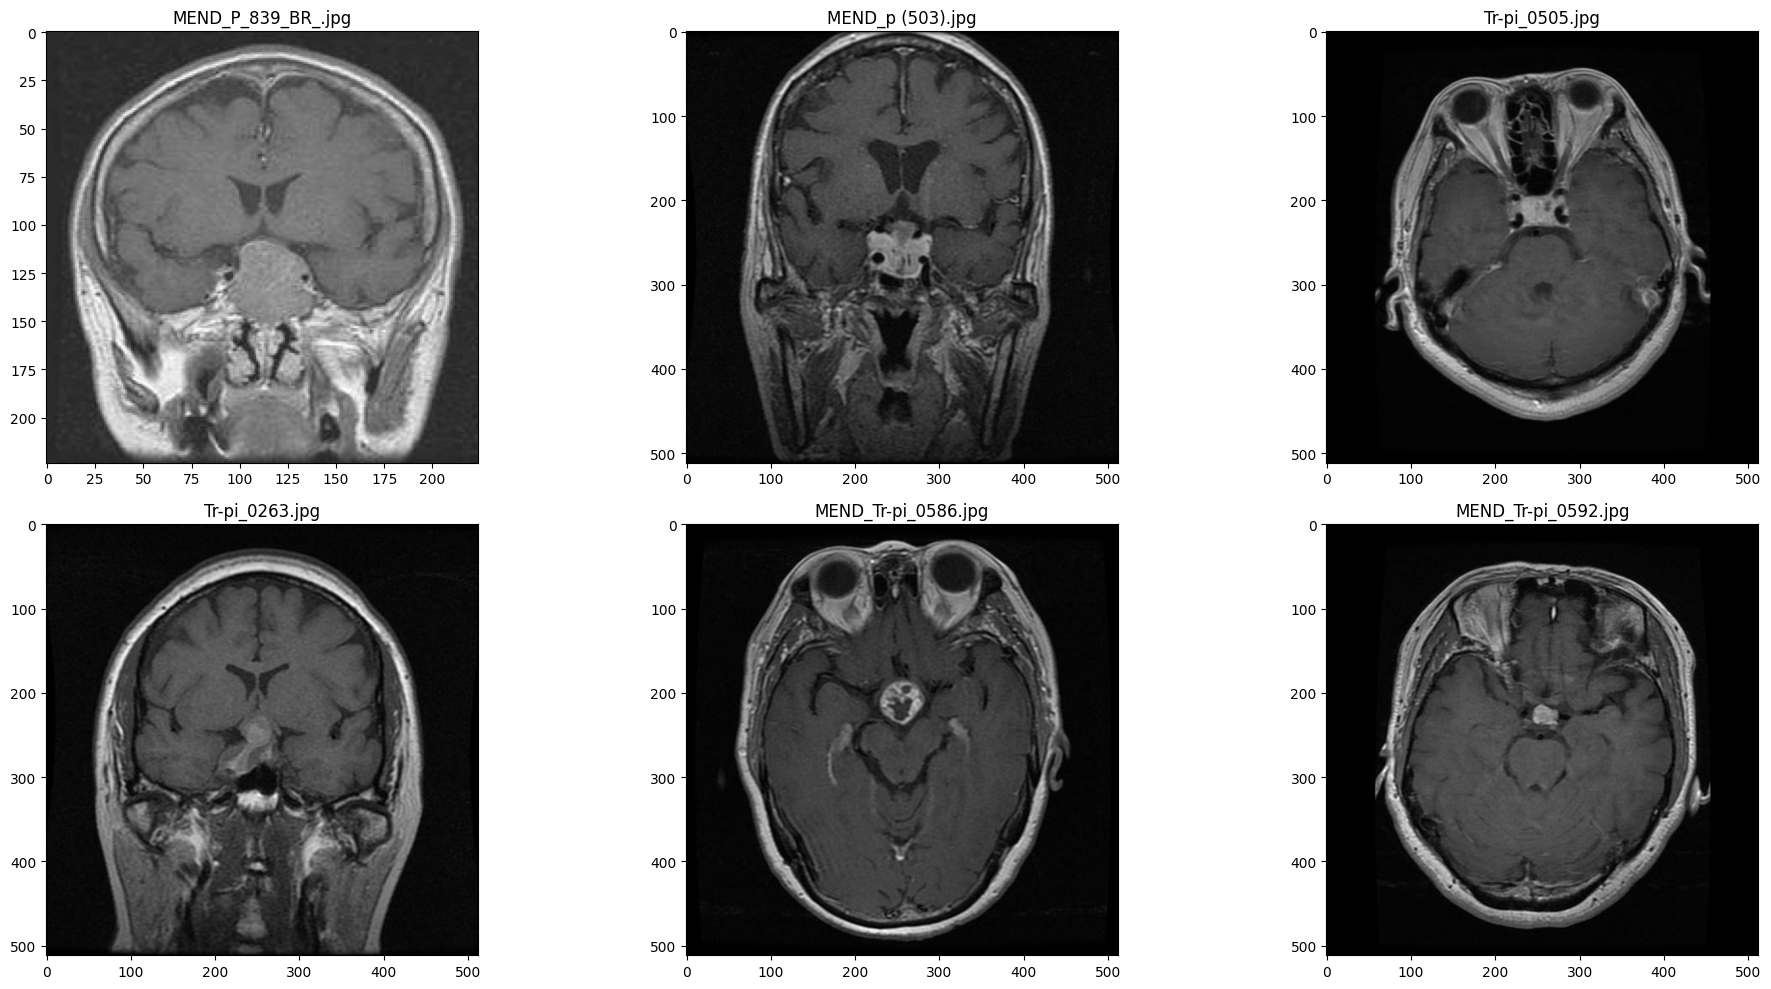

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

for ax, image_path in zip(axes, df.head(8).image_path):
    image = Image.open(image_path)
    ax.imshow(image, cmap="gray")
    ax.set_title(image_path.split("/")[-1])  # Optional: show filename

plt.tight_layout()
plt.show()

#### 2. One-hot Encoding Tumor Types

In [10]:
# One-hot encoding the tumor types
from sklearn.preprocessing import LabelEncoder

mapping = {
    'notumor': 0,
    'meningioma': 1,
    'glioma': 2,
    'pituitary': 3
}

df["tumor_type_encoded"] = df["tumor_type"].map(mapping)

#### 3. First Model Training

#####        3.1 Define image loading function and the training / validation sets

In [11]:
from tensorflow.lite.python import convert
def load_image(path):
    img = Image.open(path).convert("L")
    arr = np.array(img, dtype=np.float32)
    return arr

In [12]:
def load_process_image(path):
    img = Image.open(path).convert("L")
    img = img.resize(size=(128,128))
    arr = np.array(img, dtype=np.float32)
    arr = arr / 255.
    return arr

In [13]:
X_paths = df.image_path
X = X_paths.apply(lambda x : load_process_image(x))
X = np.stack(X, axis=0) 
X = X.reshape(-1, 128, 128, 1)
print("X shape :", X.shape)

X shape : (11410, 128, 128, 1)


In [14]:
y = df.tumor_type_encoded
print("y shape :", y.shape)

y shape : (11410,)


In [15]:
df['images'] = list(X)
df.head()

,image_path,tumor_type,tumor_type_encoded,images
0,../raw_data/classification/Training/pituitary/...,pituitary,3,"[[[0.16862746], [0.16862746], [0.16862746], [0..."
1,../raw_data/classification/Training/pituitary/...,pituitary,3,"[[[0.003921569], [0.003921569], [0.003921569],..."
2,../raw_data/classification/Training/pituitary/...,pituitary,3,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
3,../raw_data/classification/Training/pituitary/...,pituitary,3,"[[[0.007843138], [0.007843138], [0.011764706],..."
4,../raw_data/classification/Training/pituitary/...,pituitary,3,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


In [ ]:
df_full = pd.concat([df[['images', 'tumor_type', 'tumor_type_encoded']], df_charge])

In [19]:
df_charge.head()

,image,tumor_type,tumor_type_encoded
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",pituitary,3
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",pituitary,3
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",pituitary,3
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",pituitary,3
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",pituitary,3


In [18]:
df_full.head()

,images,tumor_type,tumor_type_encoded,image
0,"[[[0.16862746], [0.16862746], [0.16862746], [0...",pituitary,3,NaN
1,"[[[0.003921569], [0.003921569], [0.003921569],...",pituitary,3,NaN
2,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",pituitary,3,NaN
3,"[[[0.007843138], [0.007843138], [0.011764706],...",pituitary,3,NaN
4,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...",pituitary,3,NaN


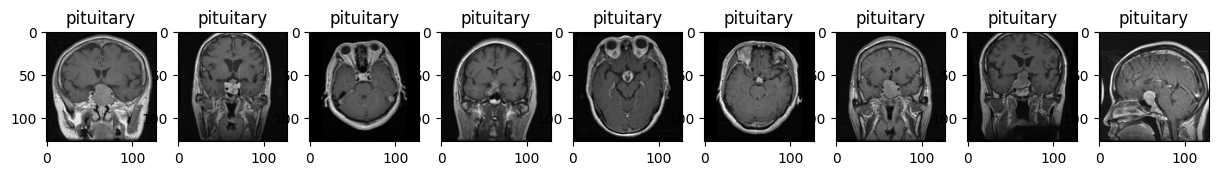

In [ ]:
plt.figure(figsize=(15,5))

for i in range(9):
    plt.subplot(1,9, i+1)
    img = X[i]
    label = y[i]
    plt.imshow(img, cmap="gray")
    plt.title(labels[label])

(128, 128, 1)


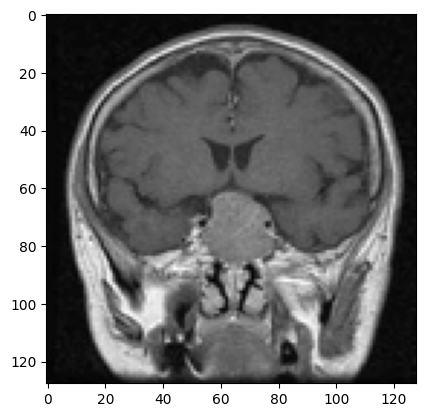

In [ ]:
print(X[0].shape)
plt.imshow(X[0], cmap="gray")

#### 3. Definie model

In [ ]:
def initialize_model():
    '''instanciate and return the CNN architecture of your choice with less than 150,000 params'''

    model = Sequential()
    model.add(Input(shape=X.shape[1:]))

    # 1st Conv Layer
    model.add(layers.Conv2D(32, (5, 5),
                            padding='same',
                            strides=(1,1),
                            activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))

    # 2nd Conv Layer
    model.add(layers.Conv2D(32, (5, 5),
                            padding='same',
                            strides=(1,1),
                            activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(4,4)))
    model.add(layers.Dropout(0.25))


    # # 3rd Conv Layer + MaxPooling + Dropout
    # model.add(layers.Conv2D(64, (3, 3),
    #                         padding='same',
    #                         strides=(1,1),
    #                         activation="relu"))
    # model.add(layers.MaxPool2D(pool_size=(2,2)))


    # Flattening
    model.add(layers.Flatten())

    # Ouput layers
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4, activation='softmax'))

    return model

In [ ]:
from tensorflow.keras.metrics import Recall

def compile_model(model):
    '''return a compiled model suited for the CIFAR-10 task'''
    model.compile(optimizer= 'adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=["accuracy"])
    return model


In [ ]:
model = initialize_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 flatten (Flatten)           (None, 8192)              0

In [ ]:
model = compile_model(model)
es = EarlyStopping(patience=3, restore_best_weights=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data= (X_val, y_val),
                    verbose=1,
                    callbacks=[es])

Epoch 1/10


2025-12-02 13:03:37.498081: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


286/286 [==============================] - 23s 79ms/step - loss: 0.8917 - accuracy: 0.6394 - val_loss: 0.6022 - val_accuracy: 0.7634
Epoch 2/10
286/286 [==============================] - 24s 84ms/step - loss: 0.6407 - accuracy: 0.7515 - val_loss: 0.5078 - val_accuracy: 0.8208
Epoch 3/10
286/286 [==============================] - 24s 82ms/step - loss: 0.5582 - accuracy: 0.7791 - val_loss: 0.4091 - val_accuracy: 0.8620
Epoch 4/10
286/286 [==============================] - 25s 86ms/step - loss: 0.4819 - accuracy: 0.8126 - val_loss: 0.3586 - val_accuracy: 0.8699
Epoch 5/10
286/286 [==============================] - 23s 81ms/step - loss: 0.4294 - accuracy: 0.8301 - val_loss: 0.3296 - val_accuracy: 0.8865
Epoch 6/10
123/286 [===========>..................] - ETA: 12s - loss: 0.3838 - accuracy: 0.8379

(2495, 2)


<Axes: xlabel='test_tumor_type', ylabel='count'>

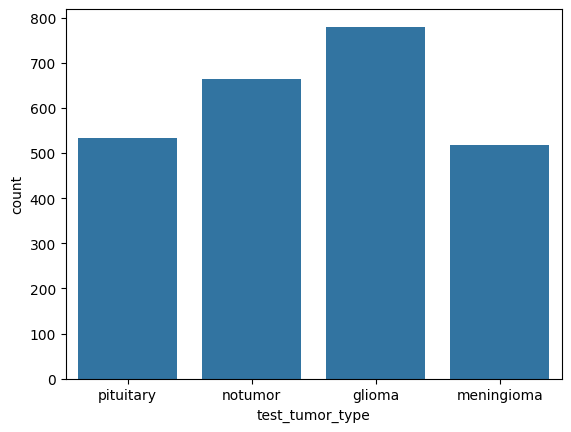

In [ ]:
# Collect image paths and their corresponding tumor types
from scipy import test


test_paths = []
test_labels = []

for tumor_type in os.listdir(test_dir):
    tumor_type_path = test_dir/tumor_type
    if os.path.isdir(tumor_type_path):
        for test_img_name in os.listdir(tumor_type_path):
            test_img_path = tumor_type_path / test_img_name
            # Optional: filter only image files
            if test_img_path.suffix.lower() in [".png", ".jpg", ".jpeg"]:
                test_paths.append(str(test_img_path))
                test_labels.append(tumor_type)

# Create a DataFrame for the dataset
test_df = pd.DataFrame({
    "test_image_path": test_paths,
    "test_tumor_type": test_labels
})

# Show the first few rows for verification
print(test_df.shape)
test_df.head(10)

sns.countplot(x="test_tumor_type", data=test_df)

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(test_df[["test_tumor_type"]])
test_df["test_tumor_type_encoded"] = label_encoder.transform(test_df[["test_tumor_type"]])
test_df.head(10)

/Users/abirbou/.pyenv/versions/3.10.6/envs/brain_tumor_detection_project/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/abirbou/.pyenv/versions/3.10.6/envs/brain_tumor_detection_project/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


,test_image_path,test_tumor_type,test_tumor_type_encoded
0,../raw_data/classification/Testing/pituitary/B...,pituitary,3
1,../raw_data/classification/Testing/pituitary/T...,pituitary,3
2,../raw_data/classification/Testing/pituitary/T...,pituitary,3
3,../raw_data/classification/Testing/pituitary/B...,pituitary,3
4,../raw_data/classification/Testing/pituitary/M...,pituitary,3
5,../raw_data/classification/Testing/pituitary/M...,pituitary,3
6,../raw_data/classification/Testing/pituitary/M...,pituitary,3
7,../raw_data/classification/Testing/pituitary/M...,pituitary,3
8,../raw_data/classification/Testing/pituitary/M...,pituitary,3
9,../raw_data/classification/Testing/pituitary/M...,pituitary,3


In [ ]:
# Define the test set
X_test_paths = test_df.test_image_path
X_test = X_test_paths.apply(lambda X_test : load_process_image(X_test))
X_test = np.stack(X_test, axis=0) 
X_test = X_test.reshape(-1, 128, 128, 1)

y_test = test_df.test_tumor_type_encoded

print(y_test.shape, X_test.shape)

(2495,) (2495, 128, 128, 1)


In [ ]:
results = model.evaluate(X_test, y_test, batch_size=32)
results

78/78 [==============================] - 1s 19ms/step - loss: 0.3714 - accuracy: 0.8693


[0.37140682339668274, 0.8693386912345886]

In [ ]:
y_pred = model.predict(X_test)

78/78 [==============================] - 1s 19ms/step


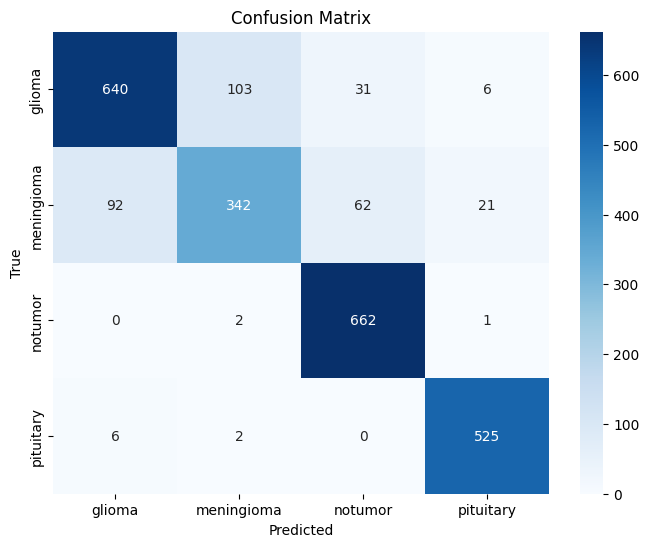

In [ ]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_true=y_test, y_pred=np.argmax(y_pred, axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# 